In [1]:
import torch
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('../')
from dataloader import get_train_and_validation_dataloader, patch_extractor

In [2]:
# Creating of Patch Extractor.
train_dataloader, validation_dataloader = get_train_and_validation_dataloader(root_dataset_dir="../../../../../../Dataset/LowDoseCTGrandChallenge/Training_Image_Data", shuffle=False)

number of image paths :  15152
number of image paths :  1472
Train and validation data image len : 15152, 1472


In [3]:
# Test to check the number of patches per image.
# The format is : number_of_images_in_batch, patch_count, patch_height, patch_width, num_channels
data = next(iter(train_dataloader))
print('len of images in batch : ', len(data))
print('shape of each image in batch : ', data[0].shape)

len of images in batch :  2
shape of each image in batch :  torch.Size([64, 512, 512, 1])


torch.Size([64, 512, 512, 1])


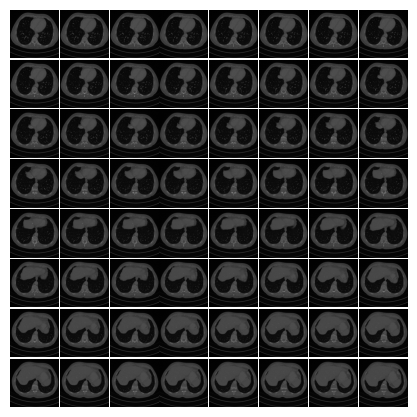

torch.Size([64, 512, 512, 1])


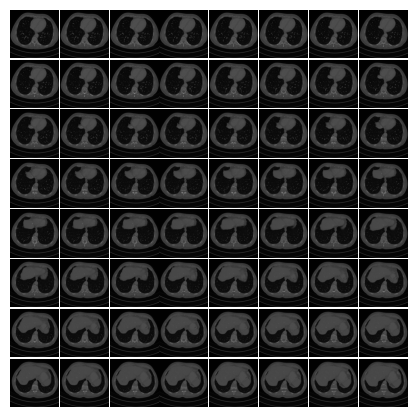

In [5]:
def display_patches_in_grid(image):
    print(image.shape)
    patch_count, patch_height, patch_width, num_channels = image.shape
    
    plt.figure(figsize=(4,4))
    
    for i in range(patch_count):
        plt.subplot(8, 8, i + 1)
        plt.imshow(image[i], cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        
    plt.tight_layout(pad=0.1)
    plt.show()
    
display_patches_in_grid(next(iter(train_dataloader))[0])
display_patches_in_grid(next(iter(train_dataloader))[1])

# Input Projection Layer

In [ ]:
class InputProjectionLayer(torch.nn.Module):
    def __init__(self, num_channels, kernel_size=(3,3)):
        super(InputProjectionLayer, self).__init__()
        
        self.conv = torch.nn.Conv2d(1, num_channels, kernel_size, padding='same')
        
    def forward(self, images):
        print(images.shape)
        images = torch.transpose(images, 3, 1)
        return self.conv(images)
    

ip = InputProjectionLayer(num_channels=32)(next(iter(train_dataloader))[0])
ip.shape

torch.Size([64, 64, 64, 1])


torch.Size([64, 32, 64, 64])

# Output Projection Layer

In [ ]:
class OutputProjectionLayer(torch.nn.Module):
    def __init__(self, num_channels, kernel_size=(3,3)):
        super(OutputProjectionLayer, self).__init__()
        
        self.conv2d_transpose = torch.nn.ConvTranspose2d(num_channels, 1, kernel_size, padding=1)
        
    def forward(self, images):
        print(images.shape)
        images = self.conv2d_transpose(images)
        images = torch.transpose(images, 3,  1)
        return images
    
op = OutputProjectionLayer(num_channels=32)(ip)
op.shape

torch.Size([64, 32, 64, 64])


torch.Size([64, 64, 64, 1])

# Convolution Block (i.e ConvNext block)

In [ ]:
class DepthWiseSeparableConv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, bias=False):
        super(DepthWiseSeparableConv2d, self).__init__()
        self.depthwise = torch.nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                               groups=in_channels, bias=bias, padding='same')
        self.pointwise = torch.nn.Conv2d(in_channels, out_channels, 
                               kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class ConvBlock(torch.nn.Module):
    def __init__(self, num_channels, width, height):
        super(ConvBlock, self).__init__()
        
        self.zero_padding = torch.nn.ZeroPad2d(padding=3)
        self.dwconv = DepthWiseSeparableConv2d(num_channels, num_channels, 7)
        self.layer_norm = torch.nn.LayerNorm([64, num_channels, width + 6, height + 6], elementwise_affine=False)
        self.linear_1 = torch.nn.Conv2d(num_channels, num_channels * 4, kernel_size=7)
        self.gelu = torch.nn.GELU()
        self.linear_2 = torch.nn.Conv2d(num_channels * 4, num_channels, kernel_size=1) 
        
    def forward(self, images):
        residual = images
        
        images = self.zero_padding(images)
        images = self.dwconv(images)
        images = self.layer_norm(images)
        images = self.linear_1(images)
        images = self.gelu(images)
        images = self.linear_2(images)
        return images + residual 

            
cb = ConvBlock(32, 64, 64)(ip)
cb.shape

torch.Size([64, 32, 64, 64])

# Hformer block

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HformerBlock(nn.Module):
    def __init__(self, maxpool_kernel_size, attention_scaling_factor, num_channels, width, height):
        super(HformerBlock, self).__init__()

        self.k = maxpool_kernel_size
        self.dk = attention_scaling_factor
        self.c = num_channels

        # Layers for path A (i.e DWConv, Norm, Linear, Gelu, Linear)
        # Depth-wise conv (applying a separate filter for each image channel)
        self.depthwise_conv = DepthWiseSeparableConv2d(num_channels, num_channels, 7) 

        # Defining the layers for path B (i.e max pooling, self-attention, linear)

        # Max pooling layers (used in attention computation for Keys and Queries)
        self.maxpool = nn.MaxPool2d(kernel_size=maxpool_kernel_size, stride=maxpool_kernel_size)

        # (Q, K, V) are used for attention.
        # This is clear from the paper which mentions:
        # The (original) self-attentive mechanism first generates the corresponding query e
        # (q), Key (K) and Value (V)
        # The output of K and Q linear are: HW/k^2 x C
        # Note that the vectors (output of self.k/q/v_linear) are PER channel (C).
        self.k_linear = nn.Linear(self.c, self.c, bias=False)
        self.q_linear = nn.Linear(self.c, self.c, bias=False)
        self.v_linear = nn.Linear(self.c, self.c, bias=False)
        self.self_attention_linear = nn.Conv2d(num_channels, num_channels, kernel_size=1)

        # Defining the layers for the stage where the input is the output of path A and path B
        self.norm = nn.LayerNorm([num_channels, height, width], elementwise_affine=False)  
        self.linear_1 = nn.Conv2d(num_channels, num_channels * 4, kernel_size=1)
        self.gelu = nn.GELU()
        self.linear_2 = nn.Conv2d(num_channels * 4, num_channels, kernel_size=1)

    def forward(self, images):
        # In the Hformer block, the input takes 2 paths.
        # In path A, images undergo depth-wise convolution (DWConv based perceptual module)
        # In path B, images undergo a transformer module with lightweight self-attention module (self-attention after max pooling)

        # Code for path A.
        path_a_output = self.depthwise_conv(images)

        # Code for path B.
        max_pooled_images = self.maxpool(images)

        # Attention module computation.
        # Q, K, V all pass through linear layers.
        # q and k are reshaped into HW / (max pool kernel size)^2 x C
        print('input shape expected by q_linear, k_linear, and v_linear: ', self.c)

        # The shape of max-pooled images is: (num_images, height', width', channels).
        # We are converting that into (num_images, height' * width', channel)
        flattened_max_pooled_images = max_pooled_images.view(max_pooled_images.size(0), -1, self.c)
        print('shape of flattened max-pooled images', flattened_max_pooled_images.shape)

        q = self.q_linear(flattened_max_pooled_images)
        # For the computation of the attention map, we need the shape of q to be num_images, num_channels, HW.
        # But now, it is num_images, HW, num_channels. The last 2 dimensions must be reversed.
        q = q.permute(0, 2, 1)
        print('shape of q: ', q.shape)

        k = self.k_linear(flattened_max_pooled_images)
        print('k shape: ', k.shape)

        flattened_images = images.view(images.size(0), -1, self.c)
        print('shape of flattened images: ', flattened_images.shape)

        v = self.v_linear(flattened_images)
        print('shape of v:', v.shape)

        # Computation of attention
        # attention = ((K'T Q) / sqrt(dk)) V
        # Ignoring num_images, the shape of Q is (num_channels)
        attention = torch.matmul(q, k)
        print('q * k shape: ', attention.shape)

        # As per the paper, after performing softmax, we obtain an attention score matrix with dimension C x C.
        # The scaling factor mentioned in the paper (i.e 1/sqrt(dk)) is based on network depth.
        attention = F.softmax(attention / torch.sqrt(torch.tensor(self.dk, dtype=torch.float32)), dim=-1)

        # Now, the final attention map is obtained by multiplying v and attention.
        attention = torch.matmul(v, attention)

        print('final attention shape: ', attention.shape)

        # Now, attention is reshaped into the same dimensions as the input image.
        path_b_output = attention.view(-1, path_a_output.size(1), path_a_output.size(2), path_a_output.size(3))
        print('path b output shape: ', path_b_output.shape)

        combined_path_output = path_a_output + path_b_output

        print('combined path output shape: ', combined_path_output.shape)

        x = combined_path_output
        x = self.norm(x)
        print('shape after layer normalization: ', x.shape)
        x = self.linear_1(x)
        print('shape after Hformer block linear 1: ', x.shape)
        x = self.gelu(x)
        print('shape after Hformer block gelu: ', x.shape)
        x = self.linear_2(x)

        print('final output shape: ', x.shape)

        return x

hformer_block = HformerBlock(maxpool_kernel_size=(2,2), attention_scaling_factor=1, num_channels=32, width=64, height=64)(cb)
hformer_block.shape

input shape expected by q_linear, k_linear, and v_linear:  32
shape of flattened max-pooled images torch.Size([64, 1024, 32])
shape of q:  torch.Size([64, 32, 1024])
k shape:  torch.Size([64, 1024, 32])
shape of flattened images:  torch.Size([64, 4096, 32])
shape of v: torch.Size([64, 4096, 32])
q * k shape:  torch.Size([64, 32, 32])
final attention shape:  torch.Size([64, 4096, 32])
path b output shape:  torch.Size([64, 32, 64, 64])
combined path output shape:  torch.Size([64, 32, 64, 64])
shape after layer normalization:  torch.Size([64, 32, 64, 64])
shape after Hformer block linear 1:  torch.Size([64, 128, 64, 64])
shape after Hformer block gelu:  torch.Size([64, 128, 64, 64])
final output shape:  torch.Size([64, 32, 64, 64])


torch.Size([64, 32, 64, 64])

# Hformer model

In [ ]:
class HformerModel(torch.nn.Module):
    def __init__(self, num_channels,width=64, height=64):
        super(HformerModel, self).__init__()
        
        self.ip = InputProjectionLayer(num_channels=num_channels)
        self.op = OutputProjectionLayer(num_channels=num_channels)
    
        self.conv_block_1 = ConvBlock(num_channels=num_channels, width=width, height=height)
        self.conv_block_2 = ConvBlock(num_channels=num_channels, width=width, height=height) 
        
        self.downsampling_layer_1 = torch.nn.Conv2d(num_channels, num_channels * 2, kernel_size=(2,2), stride=2)
        self.downsampling_layer_2 = torch.nn.Conv2d(num_channels * 2, num_channels * 4, kernel_size=(2,2), stride=2)
        
        self.upsampling_layer_1 = torch.nn.ConvTranspose2d(num_channels * 4, num_channels * 2, kernel_size=(2, 2), stride=2)
        self.upsampling_layer_2 = torch.nn.ConvTranspose2d(num_channels * 2, num_channels, kernel_size=(2, 2), stride=2)
         
        self.hformer_block_1 = HformerBlock(maxpool_kernel_size=(2,2), attention_scaling_factor=1, num_channels=num_channels * 2, width=width // 2, height=height // 2)
        self.hformer_block_2 = HformerBlock(maxpool_kernel_size=(2,2), attention_scaling_factor=1, num_channels=num_channels * 4, width=width // 4, height=height // 4)
        self.hformer_block_3 = HformerBlock(maxpool_kernel_size=(2,2), attention_scaling_factor=1, num_channels=num_channels * 2, width=width // 2, height=height // 2)
        
    def forward(self, images):
        image_after_ip = self.ip(images)
        conv_block_1_output = self.conv_block_1(image_after_ip)
        downsampling_1_output = self.downsampling_layer_1(conv_block_1_output)
        hformer_block_1_output = self.hformer_block_1(downsampling_1_output)
        downsampling_2_output = self.downsampling_layer_2(hformer_block_1_output)
        hformer_block_2_output = self.hformer_block_2(downsampling_2_output)
        print('aa', hformer_block_2_output.shape)
        upsampling_1_output = self.upsampling_layer_1(hformer_block_2_output)
        print(upsampling_1_output.shape)
        hformer_block_3_output = self.hformer_block_3(upsampling_1_output) + hformer_block_1_output
        print('bbbb', hformer_block_3_output.shape)
        upsampling_2_output = self.upsampling_layer_2(hformer_block_3_output)
        print(upsampling_2_output.shape, ' XXX')
        conv_block_2_output = self.conv_block_2(upsampling_2_output) + conv_block_1_output
        
        output = self.op(conv_block_2_output) + images
        
        return output 
    
hm = HformerModel(num_channels=4)(next(iter(train_dataloader))[0])
hm.shape

torch.Size([64, 64, 64, 1])
input shape expected by q_linear, k_linear, and v_linear:  8
shape of flattened max-pooled images torch.Size([64, 256, 8])
shape of q:  torch.Size([64, 8, 256])
k shape:  torch.Size([64, 256, 8])
shape of flattened images:  torch.Size([64, 1024, 8])
shape of v: torch.Size([64, 1024, 8])
q * k shape:  torch.Size([64, 8, 8])
final attention shape:  torch.Size([64, 1024, 8])
path b output shape:  torch.Size([64, 8, 32, 32])
combined path output shape:  torch.Size([64, 8, 32, 32])
shape after layer normalization:  torch.Size([64, 8, 32, 32])
shape after Hformer block linear 1:  torch.Size([64, 32, 32, 32])
shape after Hformer block gelu:  torch.Size([64, 32, 32, 32])
final output shape:  torch.Size([64, 8, 32, 32])
input shape expected by q_linear, k_linear, and v_linear:  16
shape of flattened max-pooled images torch.Size([64, 64, 16])
shape of q:  torch.Size([64, 16, 64])
k shape:  torch.Size([64, 64, 16])
shape of flattened images:  torch.Size([64, 256, 16])


torch.Size([64, 64, 64, 1])

In [ ]:
from torchinfo import summary
summary(HformerModel(num_channels=64), (1, 64, 64, 1)) 

torch.Size([64, 64, 64, 1])
input shape expected by q_linear, k_linear, and v_linear:  128
shape of flattened max-pooled images torch.Size([64, 256, 128])
shape of q:  torch.Size([64, 128, 256])
k shape:  torch.Size([64, 256, 128])
shape of flattened images:  torch.Size([64, 1024, 128])
shape of v: torch.Size([64, 1024, 128])
q * k shape:  torch.Size([64, 128, 128])
final attention shape:  torch.Size([64, 1024, 128])
path b output shape:  torch.Size([64, 128, 32, 32])
combined path output shape:  torch.Size([64, 128, 32, 32])
shape after layer normalization:  torch.Size([64, 128, 32, 32])
shape after Hformer block linear 1:  torch.Size([64, 512, 32, 32])
shape after Hformer block gelu:  torch.Size([64, 512, 32, 32])
final output shape:  torch.Size([64, 128, 32, 32])
input shape expected by q_linear, k_linear, and v_linear:  256
shape of flattened max-pooled images torch.Size([64, 64, 256])
shape of q:  torch.Size([64, 256, 64])
k shape:  torch.Size([64, 64, 256])
shape of flattened ima

Layer (type:depth-idx)                        Output Shape              Param #
HformerModel                                  [64, 64, 64, 1]           --
├─InputProjectionLayer: 1-1                   [64, 64, 64, 64]          --
│    └─Conv2d: 2-1                            [64, 64, 64, 64]          640
├─ConvBlock: 1-2                              [64, 64, 64, 64]          --
│    └─ZeroPad2d: 2-2                         [64, 64, 70, 70]          --
│    └─DepthWiseSeparableConv2d: 2-3          [64, 64, 70, 70]          --
│    │    └─Conv2d: 3-1                       [64, 64, 70, 70]          3,136
│    │    └─Conv2d: 3-2                       [64, 64, 70, 70]          4,096
│    └─LayerNorm: 2-4                         [64, 64, 70, 70]          --
│    └─Conv2d: 2-5                            [64, 256, 64, 64]         803,072
│    └─GELU: 2-6                              [64, 256, 64, 64]         --
│    └─Conv2d: 2-7                            [64, 64, 64, 64]          16,448
├─Co